The purpose of the example notebooks is to provide quick view to the power of the framework, and its purpose.
It is not documentation - documentation may be available in the future, if will be needed and requested.

In [1]:
from src.motion_models.trajectory_generation.route_generation import *
from src.visual.visual_tools import *

import numpy as np

%load_ext autoreload
%autoreload 2

### Constant-Velocity Model

MSE for k=1: 0.05972510467464471
MSE for k=5: 0.2070969218203662


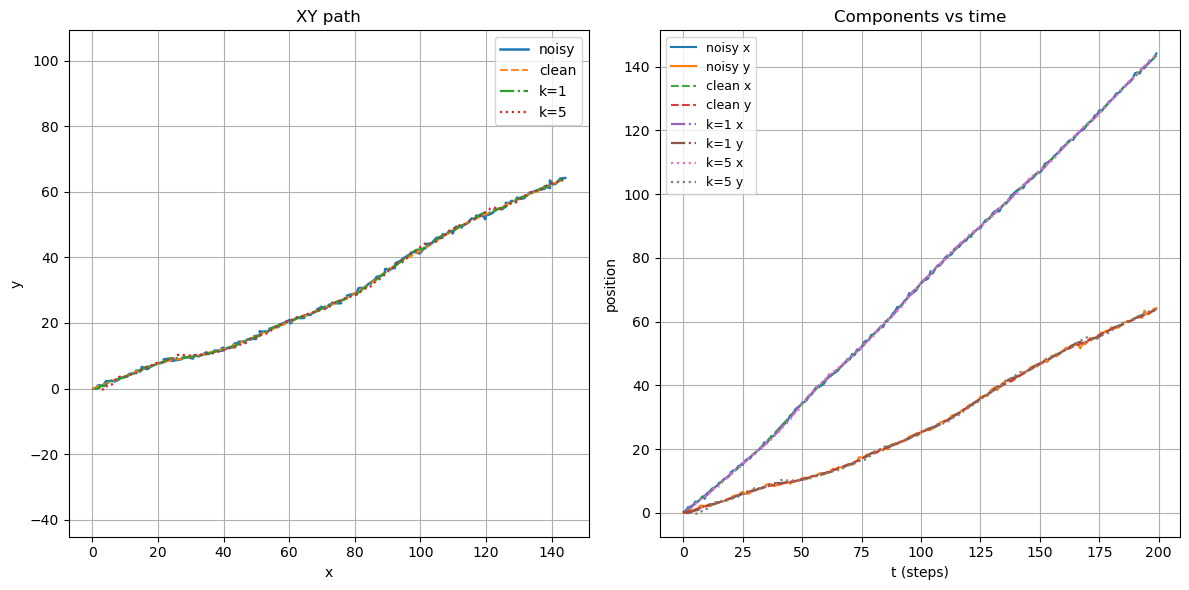

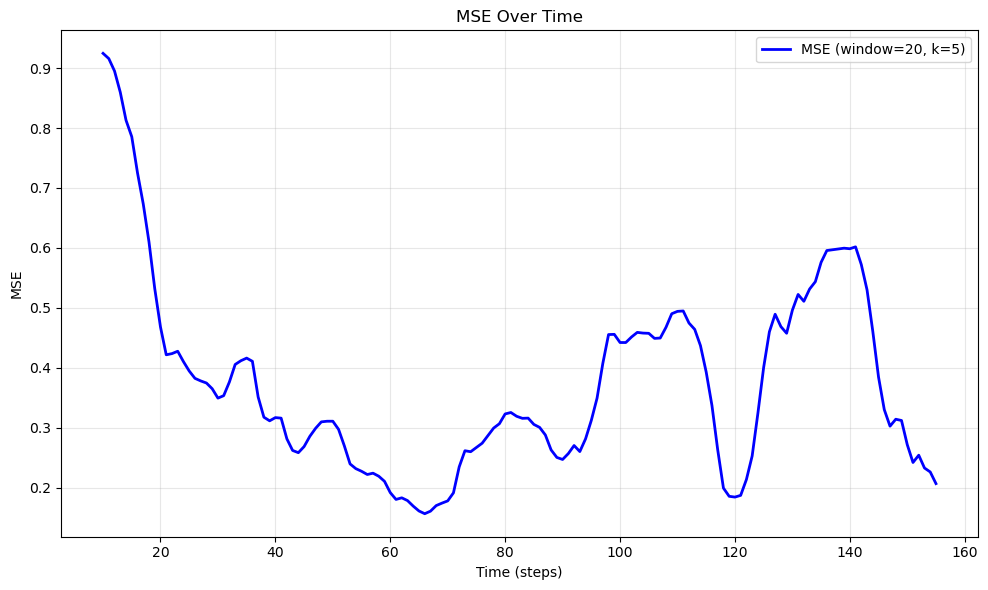

(array([0.92461012, 0.91587055, 0.89506675, 0.85962673, 0.81299362,
        0.78543606, 0.7250599 , 0.67321161, 0.6097014 , 0.53198679,
        0.46785208, 0.42154379, 0.4235219 , 0.42744962, 0.41007694,
        0.39447964, 0.38223531, 0.37795194, 0.37443167, 0.36492078,
        0.34923906, 0.35329369, 0.37627103, 0.4053709 , 0.41164642,
        0.41600374, 0.41066132, 0.35115166, 0.31738422, 0.31134375,
        0.31670693, 0.31580664, 0.28130646, 0.26189269, 0.25816711,
        0.26838056, 0.28548558, 0.29882691, 0.30958917, 0.31065012,
        0.31067296, 0.29709051, 0.26968469, 0.23942961, 0.23157215,
        0.22714199, 0.22174796, 0.22397042, 0.21885762, 0.21033935,
        0.19152531, 0.1801611 , 0.18283861, 0.17824757, 0.1689515 ,
        0.1608561 , 0.15632814, 0.16053775, 0.16988491, 0.17398935,
        0.17770384, 0.19114253, 0.23448592, 0.26141446, 0.25976552,
        0.2668237 , 0.27400744, 0.28668707, 0.2992718 , 0.30652353,
        0.32285105, 0.32521112, 0.31891965, 0.31

In [2]:
from src.filters.cv_kalman_filter import CVKalmanFilter, InitializationData

NOISE = np.array([0.4,0.4])
PROCESS_NOISE_STD = np.array([0.5,0.5])
dt=0.04
initial_velocity = np.array([14,5])
initial_position = np.array([0,0])
k_lag=5


initial_trajectory_state = TrajectoryState(position=initial_position, velocity=initial_velocity)
trajectories = generate_cv_trajectory(T=200, dt=dt, initial_state=initial_trajectory_state, number_of_trajectories=1, measurement_noise_std=NOISE, vel_change_std=PROCESS_NOISE_STD, seed=44)

test_traj = trajectories[0][0]
clean_test_traj = trajectories[0][1]


# Initialzing the KF
initial_matrices_data = InitializationData(observation_noise_std=NOISE, process_noise_std=PROCESS_NOISE_STD)

base_kf = CVKalmanFilter(2, 4, 2, dt, initial_matrices_data)
base_kf.initialize()

mse_k1, preds_k1= base_kf.evaluate_on_trajectory(
    test_traj,
    clean_test_traj,
    normalize_mse=False,
    return_predictions=True)

base_kf.initialize()
mse_k_lag, preds_k_lag= base_kf.evaluate_on_trajectory(
    test_traj,
    clean_test_traj,
    k=k_lag,
    normalize_mse=False,
    return_predictions=True)

print(f"MSE for k=1: {mse_k1}")
print(f"MSE for k={k_lag}: {mse_k_lag}")

plot_trajectories_with_predictions_shifted(test_traj, clean_test_traj, [(preds_k1, 1), (preds_k_lag, k_lag)])


calculate_and_plot_mse_sliding_window(
    preds_k_lag[30:], #start showing after 30 to ignore the first iterations which are "calibrating" the values etc.
    clean_test_traj[30:],
    k_lag=k_lag,
    window_size=20,
    use_clean_signal=True,
    normalize_mse=False,
    title="MSE Over Time",
)

### Constant-Acceleration Model

MSE for k=1: 0.020953213562323172
MSE for k=5: 0.15936871220406934


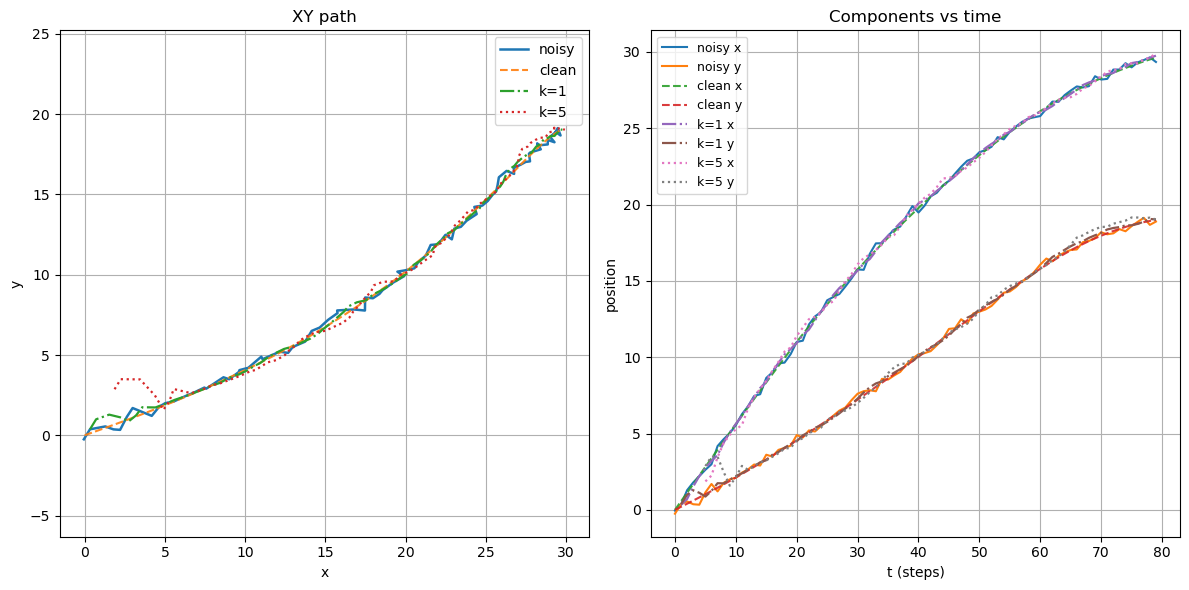

In [3]:
from src.filters.ca_kalman_filter import CAKalmanFilter, InitializationData

dt = 0.04
NOISE = np.array([0.2,0.2])
white_accel_density = 10
accel_noise_std = np.sqrt(dt * white_accel_density)
initial_acceleration = np.array([1, 1])
initial_velocity = np.array([14,5])
initial_position = np.array([0,0])

initial_trajectory_state = TrajectoryState(position=initial_position, velocity=initial_velocity, acceleration=initial_acceleration)
trajectories = generate_ca_trajectory(T=80, dt=dt,initial_state=initial_trajectory_state, measurement_noise_std=NOISE, number_of_trajectories=1, seed=43, accel_noise_std=accel_noise_std)

test_traj = trajectories[0][0]
clean_test_traj = trajectories[0][1]

initial_matrices_data = InitializationData(observation_noise_std=NOISE, white_accel_density=white_accel_density)
base_kf = CAKalmanFilter(2, 6, 2, dt, initial_matrices_data)
base_kf.initialize()

mse_k1, preds_k1= base_kf.evaluate_on_trajectory(
    test_traj,
    clean_test_traj,
    normalize_mse=False,
    return_predictions=True)

base_kf.initialize()
mse_k_lag, preds_k_lag= base_kf.evaluate_on_trajectory(
    test_traj,
    clean_test_traj,
    k=k_lag,
    normalize_mse=False,
    return_predictions=True)

print(f"MSE for k=1: {mse_k1}")
print(f"MSE for k={k_lag}: {mse_k_lag}")

plot_trajectories_with_predictions_shifted(test_traj, clean_test_traj, [(preds_k1, 1), (preds_k_lag, k_lag)])

### Coordinated Turn Model

MSE for k=1: 0.03162196105543953
MSE for k=5: 0.0852431036117928


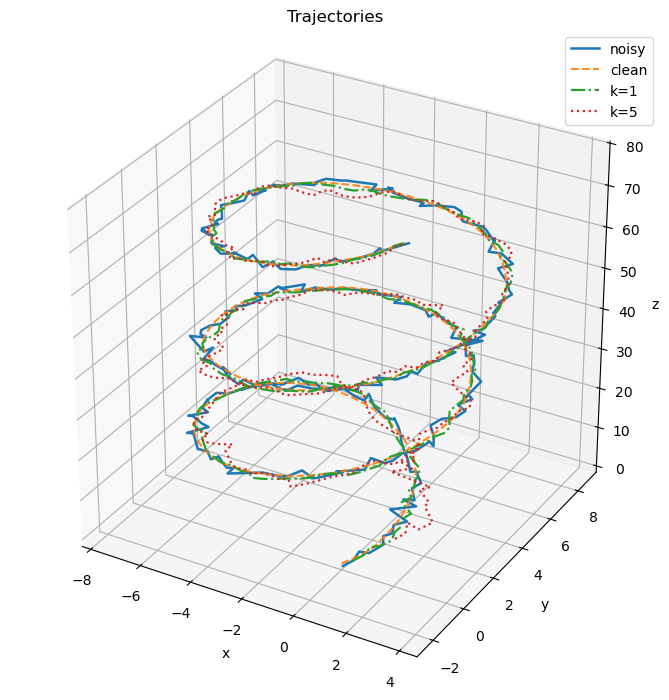

In [4]:
from src.filters.ct_kalman_filter import CTKalmanFilter
NOISE = np.array([0.2,0.2, 0.2])
ACCL_STD = 1e-1
OMEGA_STD = 1e0
omega = 2
pos_start = np.array([0,0,0])
v0 = np.array([5, 7, 8])
z_accel = 3.0
dt = 0.04

initial_generation_state = TrajectoryState(position=pos_start, velocity=v0, acceleration=np.array([0,0,z_accel]))
trajectories = generate_ct_trajectory_simple(T=250, dim=3, dt=dt, omega=omega, initial_state=initial_generation_state, measurement_noise_std=NOISE, omega_noise_std=OMEGA_STD, number_of_trajectories=10,seed=44)

test_traj = trajectories[1][0]
clean_test_traj = trajectories[1][1]


initial_matrices_data = InitializationData(observation_noise_std=NOISE, omega_std=OMEGA_STD, process_noise_std=np.array([0,0, ACCL_STD]))
base_kf = CTKalmanFilter(3, 10, 3, dt=dt, initialization_data=initial_matrices_data)
base_kf.initialize()

mse_k1, preds_k1 = base_kf.evaluate_on_trajectory(
    test_traj,
    clean_test_traj,
    normalize_mse=False,
    return_predictions=True)

base_kf.initialize()
mse_k_lag, preds_k_lag = base_kf.evaluate_on_trajectory(
    test_traj,
    clean_test_traj,
    k=k_lag,
    normalize_mse=False,
    return_predictions=True)

print(f"MSE for k=1: {mse_k1}")
print(f"MSE for k={k_lag}: {mse_k_lag}")

plot_trajectories_with_predictions_shifted(test_traj, clean_test_traj, [(preds_k1, 1), (preds_k_lag, k_lag)])
### Coordinated Turn Model

### Singer Model

MSE for k=1: 0.08298268715990802
MSE for k=5: 0.5518099090421025


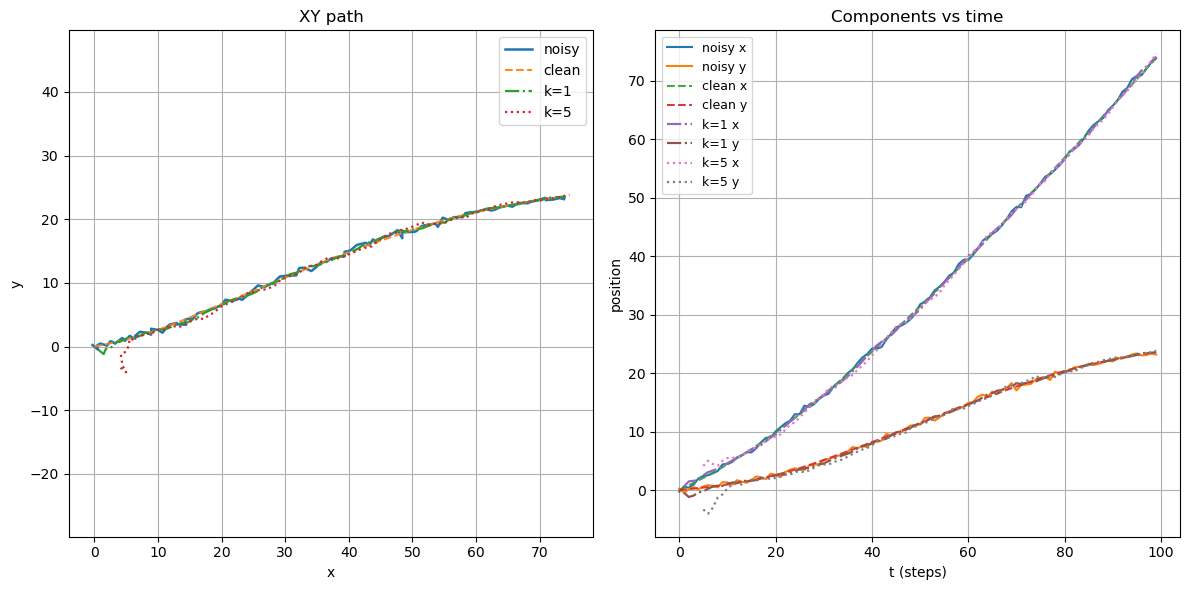

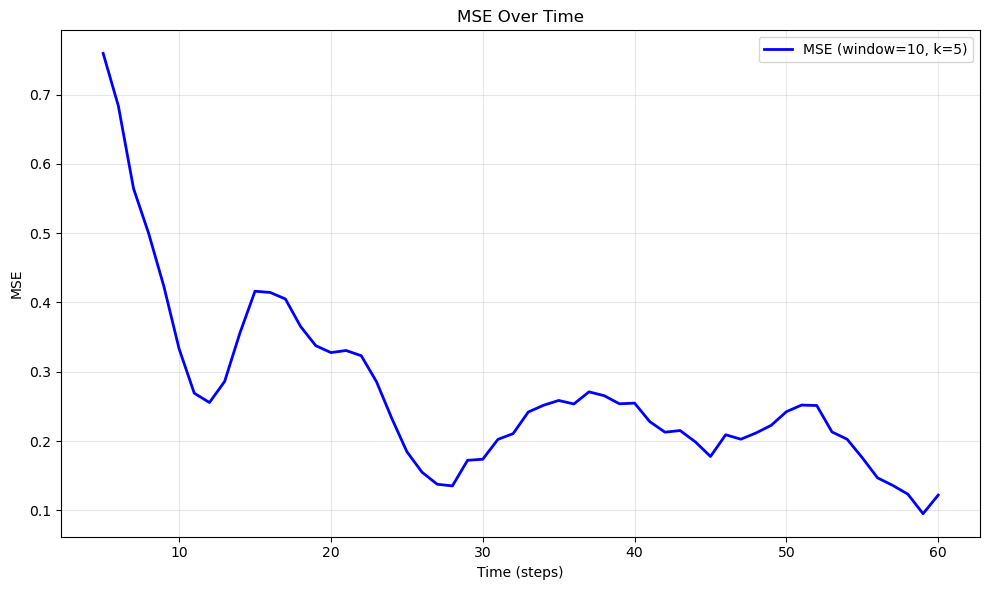

(array([0.75939382, 0.68366025, 0.5645168 , 0.49936703, 0.42307899,
        0.33328318, 0.26913598, 0.25567638, 0.28601693, 0.35544816,
        0.41621151, 0.41444693, 0.4050897 , 0.36545984, 0.33772707,
        0.32770058, 0.33071973, 0.3231436 , 0.28576725, 0.23333602,
        0.18486111, 0.15512929, 0.13776318, 0.1353335 , 0.17231237,
        0.17383917, 0.20249279, 0.21080474, 0.24196674, 0.25166295,
        0.25863357, 0.25356811, 0.27106036, 0.26551712, 0.25386558,
        0.25479599, 0.22811206, 0.21289923, 0.21523957, 0.19895019,
        0.17781356, 0.20916674, 0.20273968, 0.21177162, 0.22278225,
        0.24245133, 0.25201431, 0.25132474, 0.21321962, 0.20267765,
        0.17590643, 0.14700047, 0.13611645, 0.12347714, 0.09526868,
        0.12221796]),
 array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
  

In [5]:
from src.filters.singer_model_kalman_filter import SingerKF, InitializationData

dt=0.04
tau = np.array([5, 5])
accel_std = np.array([4,4])
v0 = np.array([10, 2])
a0 = np.array([4, 2])
pos_start = np.array([0,0])
NOISE = np.array([0.3, 0.3])

initial_generation_state = TrajectoryState(position=pos_start, velocity=v0, acceleration=a0)
trajectories = generate_singer_trajectory(
    T=100,
    dt=dt,
    initial_state=initial_generation_state,
    tau=tau,
    dim=2,
    sigma_a=accel_std,
    noise_std=NOISE,
    number_of_trajectories=10,
    seed=18)

traj_noisy = trajectories[0][0]
traj_clean = trajectories[0][1]

init = InitializationData(
    observation_noise_std=NOISE,    # e.g., meters
    process_noise_std=accel_std) # sigma_a per axis (m/s^2)
base_kf = SingerKF(dim=2, dt=dt, tau=tau, initialization_data=init)  # tau in seconds (maneuver correlation time)
base_kf.initialize()
mse_k1, preds_k1 = base_kf.evaluate_on_trajectory(
    traj_noisy,
    traj_clean,
    normalize_mse=False,
    return_predictions=True)

base_kf.initialize()
mse_k_lag, preds_k_lag = base_kf.evaluate_on_trajectory(
    traj_noisy,
    traj_clean,
    k=k_lag,
    normalize_mse=False,
    return_predictions=True)

print(f"MSE for k=1: {mse_k1}")
print(f"MSE for k={k_lag}: {mse_k_lag}")

plot_trajectories_with_predictions_shifted(traj_noisy, traj_clean, [(preds_k1, 1), (preds_k_lag, k_lag)])


calculate_and_plot_mse_sliding_window(
    preds_k_lag[30:],
    traj_clean[30:],
    k_lag=k_lag,
    window_size=10,
    use_clean_signal=True,
    normalize_mse=False,
    title="MSE Over Time",
)